In [63]:
# Kevin Jesús Banda Azogil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
import random
from IPython.display import display, Markdown
from numba import njit, prange

## Funciones y elementos comunes a todos:

In [64]:
# Colores ANSI para resaltar texto
RED = "\033[91m"
CYAN = "\033[96m"
GREEN = "\033[92m"
RESET = "\033[0m"

# Orden deseado de los archivos
NombreArchivos = ["DataSets/tai25b.dat", "DataSets/sko90b.dat", "DataSets/tai150b.dat"]
# Costos mínimos de referencia
CostoSoluciones = {
    "DataSets/tai25b.dat": 344355646,
    "DataSets/sko90b.dat": 115534,
    "DataSets/tai150b.dat": 498896643
}

semillas = [769123, 8435, 423543, 656343, 80987]


In [65]:
def leer_archivo_y_extraer_matrices(nombre_archivo):
    with open(nombre_archivo, "r") as f:
        # Leer la primera línea para obtener `n`
        n = int(f.readline().strip())  

        # Leer el resto del archivo con np.loadtxt
        datos = np.loadtxt(f, dtype=int)

    # Dividir los datos en dos matrices
    distancia = datos[:n, :n]  # Primera parte de la matriz
    flujo = datos[n:, :n]      # Segunda parte de la matriz

    return distancia, flujo, n


# Mostrar matriz (sin cambios)
def mostrar_matriz(nombre, matriz):
    print(f"Matriz {nombre}:")
    print("\n".join(" ".join(map(str, fila)) for fila in matriz))
    print()

# Gráfica de evolución del costo
def graficar_evolucion(historial_costos, titulo_extra="", linea_referencia=None):
    plt.plot(historial_costos, label="Mejor costo encontrado", color="blue")
    
    if linea_referencia is not None:
        plt.axhline(y=linea_referencia, color='red', linestyle='--', label=f"Costo Mejor Solución ({linea_referencia})")
    
    plt.xlabel("Iteraciones")
    plt.ylabel("Costo")
    plt.title(f"Evolución del costo - {titulo_extra}")
    plt.legend()
    plt.grid()
    plt.show(block=False)  # Mostrar sin detener ejecución

# Cálculo del costo usando NumPy para evitar bucles anidados
@njit
def calcular_costo(solucion, distancia, flujo, n):
    costo = 0
    for i in prange(n):
        si = solucion[i]
        for j in range(n):
            sj = solucion[j]
            costo += distancia[i][j] * flujo[si][sj]
    return costo

@njit
def calcular_costo_swap(solucion, distancia, flujo, n, i, j, costo_actual):
    si = solucion[i]
    sj = solucion[j]
    delta = 0

    for k in range(n):
        if k != i and k != j:
            sk = solucion[k]

            delta += (
                (distancia[i][k] - distancia[j][k]) * (flujo[sj][sk] - flujo[si][sk]) +
                (distancia[k][i] - distancia[k][j]) * (flujo[sk][sj] - flujo[sk][si])
            )
    
    # Diagonales y cruzados
    delta += (distancia[i][i] - distancia[j][j]) * (flujo[sj][sj] - flujo[si][si])
    delta += (distancia[i][j] - distancia[j][i]) * (flujo[sj][si] - flujo[si][sj])

    return costo_actual + delta


# Comprobacion de la funcion de costo

In [66]:
# Soluciones ideales
Sol_tai25b = [4, 15, 10, 9, 13, 5, 25, 19, 7, 3, 17, 6, 18, 20, 16, 2, 22, 23, 8, 11, 21, 24, 14, 12, 1]
Sol_sko90b = [86, 27, 9, 88, 76, 41, 52, 38, 79, 8, 48, 59, 75, 84, 16, 44, 40, 61, 58, 25, 50, 30, 49, 
    80, 57, 66, 63, 74, 43, 82, 71, 69, 15, 3, 7, 19, 78, 13, 17, 53, 23, 36, 12, 37, 28,
    51, 6, 14, 77, 29, 34, 56, 70, 65, 83, 47, 54, 4, 1, 2, 31, 60, 10, 89, 90, 26, 81, 73, 21, 64, 
    22, 45, 55, 68, 85, 35, 32, 62, 87, 42, 11, 18, 46, 20, 33, 72, 39, 67, 24, 5]
Sol_tai150b = [84, 63, 115, 19, 58, 65, 51, 105, 103, 6, 30, 27, 83, 123, 99, 25, 147, 31, 125, 48, 47, 116,
        76, 144, 104, 82, 113, 61, 109, 111, 132, 93, 54, 88, 141, 128, 110, 37, 146, 64, 130, 68,
        124, 46, 121, 73, 92, 114, 74, 13, 22, 75, 138, 142, 119, 148, 126, 69, 42, 18, 53, 133, 131,
        16, 89, 87, 137, 39, 120, 24, 21, 71, 2, 9, 91, 4, 97, 90, 149, 26, 60, 66, 122, 100, 56, 95,
        127, 136, 20, 96, 77, 57, 49, 102, 139, 134, 35, 72, 29, 112, 32, 78, 41, 80, 129, 94, 36, 8,
        14, 33, 40, 12, 106, 98, 34, 143, 150, 28, 117, 7, 67, 101, 108, 81, 107, 70, 5, 1, 55, 3, 118,
        52, 10, 85, 79, 15, 23, 62, 43, 44, 38, 135, 45, 59, 145, 140, 50, 86, 17, 11]

# Diccionario con las soluciones ideales indexadas por archivo
ArraySoluciones = {
    "DataSets/tai25b.dat": Sol_tai25b,
    "DataSets/sko90b.dat": Sol_sko90b,
    "DataSets/tai150b.dat": Sol_tai150b
}



for i, Archivo in enumerate(NombreArchivos) :
    print(f"-------------------------------------------------------------------\n{GREEN}Archivo: {Archivo}{RESET}")
    distancia, flujo, n = leer_archivo_y_extraer_matrices(Archivo)
    # Restar 1 a cada elemento del array para hacer compatible con las soluciones de los algoritmos
    numeros = [x - 1 for x in ArraySoluciones[Archivo]]
    costo = calcular_costo(numeros,  distancia, flujo,n) # El calculo de la solucion esta al reves, flujo distancia
    print("Costo Calculado:",costo, "Costo estimado:", CostoSoluciones[Archivo])

print("-------------------------------------------------------------------\nPrueba acabada")

-------------------------------------------------------------------
Archivo: DataSets/tai25b.dat
Costo Calculado: 344355646 Costo estimado: 344355646
-------------------------------------------------------------------
Archivo: DataSets/sko90b.dat
Costo Calculado: 115534 Costo estimado: 115534
-------------------------------------------------------------------
Archivo: DataSets/tai150b.dat
Costo Calculado: 498896643 Costo estimado: 498896643
-------------------------------------------------------------------
Prueba acabada


# Algoritmos:
Greedy:

In [67]:
def greedy_qap(distancia, flujo, n):
    ev=0
    potencialFlujo = []
    potencialDistancia = []

    #Calculo del potencial de distancia
    for j in range(n):
        potencialDistancia.append([sum(distancia[j]),j])
    potencialDistancia.sort(reverse=False, key=lambda x: x[0]) #De menor a mayor

    #Calculo del potencial de flujo
    for i in range(n):
        potencialFlujo.append([sum(flujo[i]),i])
    potencialFlujo.sort(reverse=True, key=lambda x: x[0]) #De mayor a menor
   
    asignaciones = [] # [unidad, localizacion]

    for i in range(n):
        asignaciones.append([potencialFlujo[i][1],potencialDistancia[i][1]])

    asignaciones.sort(reverse=False, key=lambda x: x[0])
    resultado = [subarray[1] for subarray in asignaciones]

    return resultado, calcular_costo(resultado, distancia, flujo, n), (ev+1)



Busqueda Aleatoria:

In [68]:
def busqueda_aleatoria(distancia, flujo, n, semilla):
    np.random.seed(semilla)  

    ev=0
    
    iteracionesPorN = 1000
    iteraciones = iteracionesPorN * n

    mejor_solucion = None
    mejor_costo = float("inf")
    historial_costos = []  
    
    for i in range(iteraciones):
        # Generamos una solucion inicial (GSI)
        solucion = np.random.permutation(n)  # Permutacion aleatoria
        costo = calcular_costo(solucion, distancia, flujo, n)  # Funcion objetivo (FO)
        ev=ev+1
        
        if costo < mejor_costo:
            mejor_costo = costo
            mejor_solucion = solucion.copy()  # Copia para evitar referencias
        
        historial_costos.append(mejor_costo)  # Guardamos el mejor costo de la iteracion
    
    return mejor_solucion, mejor_costo, historial_costos, ev


Busqueda Local Del Mejor Vecino:

In [ ]:
def busqueda_local_mejor_vecino(distancia, flujo, n, semilla):
    np.random.seed(semilla)
    solucion = np.arange(n)
    np.random.shuffle(solucion)
    return Algo_busqueda_local_mejor_vecino(distancia, flujo, n, solucion.copy())

@njit
def Algo_busqueda_local_mejor_vecino(distancia, flujo, n, solucion):
    costo = calcular_costo(solucion, distancia, flujo, n)
    ev=1 # Contamos el costo inicial

    historial_costos = []

    while True:
        mejora = False
        mejor_costo = costo
        mejor_i, mejor_j = -1, -1

        for i in range(n):
            for j in range(i + 1, n):            
                nuevo_costo = calcular_costo_swap(solucion, distancia, flujo, n, i, j, costo)
                ev = ev+1
                if nuevo_costo < mejor_costo:
                    mejor_costo = nuevo_costo
                    mejor_i, mejor_j = i, j
                    mejora = True

        if mejora:
            tmp = solucion[mejor_i]
            solucion[mejor_i] = solucion[mejor_j]
            solucion[mejor_j] = tmp
            costo = mejor_costo
            historial_costos.append(costo)
        else:
            break

    return solucion, costo, historial_costos, ev




Busqueda Local Del Primer Mejor Vecino:

In [ ]:
def busqueda_local_primer_mejor(distancia, flujo, n, semilla):
    np.random.seed(semilla)
    solucion = np.arange(n)
    np.random.shuffle(solucion)
    return Algo_busqueda_local_primer_mejor(distancia, flujo, n, solucion.copy())


@njit
def Algo_busqueda_local_primer_mejor(distancia, flujo, n, solucion):
    costo = calcular_costo(solucion, distancia, flujo, n)
    ev=1 # Contamos la evaluacion inicial 
    historial_costos = []

    while True:
        mejora = False

        for i in range(n):
            for j in range(i + 1, n):
                nuevo_costo = calcular_costo_swap(solucion, distancia, flujo, n, i, j, costo)
                ev=ev+1
                if nuevo_costo < costo:
                    tmp = solucion[i]
                    solucion[i] = solucion[j]
                    solucion[j] = tmp
                    costo = nuevo_costo
                    historial_costos.append(costo)
                    mejora = True
                    break  # Salta al siguiente ciclo si se mejora
            if mejora:
                break

        if not mejora:
            break

    return solucion, costo, historial_costos, ev


Enfriamineto Simulado:

In [70]:
def temp_inicial(u, ci, o):
    return (u / (-np.log(o))) * ci

def generar_vecino(solucion):
    vecino = solucion.copy()
    i, j = np.random.choice(len(solucion), 2, replace=False)
    vecino[i], vecino[j] = vecino[j], vecino[i]  # Intercambio de posiciones
    return vecino, i,j

def enfriamiento_simulado(distancia, flujo, n, semilla, solucion=None):
    np.random.seed(semilla)
    ev=0
    u, o = 0.3, 0.3  # Parametros para el calculo de T0

    if solucion is None:
        solucion, costo, _, evAux = busqueda_aleatoria(distancia, flujo, n, semilla=semilla)
        ev=ev+evAux
    else:
        costo = calcular_costo(solucion, distancia, flujo, n)
        ev=ev+1

    T0 = temp_inicial(u, costo, o)
    T = T0
    max_enfriamientos = 50 * n
    historial_costos = []

    for k in range(max_enfriamientos):
        aceptados = 0
        for _ in range(40):  # Intentos por temperatura
            vecino,i,j = generar_vecino(solucion) # Numero maximo de vecinos
            costo_vecino = calcular_costo_swap(solucion, distancia, flujo, n,i,j, costo)
            ev=ev+1

            delta = costo_vecino - costo # Diferencia entre la solucion actual y la vecina

            # si tiene menos costo el nuevo vecino aceptamos, añadimos probabilidad de aceptacion en caso de q sea peor
            if delta < 0 or np.random.rand() < np.exp(-delta / T): 
                solucion, costo = vecino, costo_vecino
                aceptados += 1

            historial_costos.append(costo)  # Se almacena en cada iteracion

            if aceptados >= 5:
                break  

        T = T0 / (1 + k)  # Esquema de enfriamiento de Cauchy

    return solucion, costo, historial_costos, ev  # Devolver historial como array



Busqueda Tabu:

In [71]:
def busqueda_tabu_qap(distancia, flujo, n, semilla):
    np.random.seed(semilla)
    ev=0
    iteraciones_max = 40 * n # El numero maximo de iteraciones en total
    # reinicios = 4 # reinicializaciones
    # iteraciones_por_reinicio = iteraciones_max // reinicios
    iteraciones_por_reinicio = 8*n
    lista_tabu_tam = 2
    
    # Generamos solucion inicial
    mejor_solucion = np.random.permutation(n)
    mejor_costo = calcular_costo(mejor_solucion, distancia, flujo, n)
    ev=ev+1
    solucion_actual = mejor_solucion.copy()
    costo_actual = mejor_costo
    # Inicializamos la lista tabu y el historial de costo
    lista_tabu = []
    historial_costos = []
    
    for iteracion in range(iteraciones_max):
        #Generamos los veccinos 
        vecinos = []
        for _ in range(40): # Examinamos 40 vecinos
            i, j = np.random.choice(n, 2, replace=False)
            vecino = solucion_actual.copy()
            vecino[i], vecino[j] = vecino[j], vecino[i]
            costo_vecino = calcular_costo_swap(solucion_actual, distancia, flujo, n, i,j, costo_actual)
            ev=ev+1
            vecinos.append((vecino, costo_vecino, (i, j))) # Lista de vecinos, con el vacino, el costo y el movimiento
        
        # ordena la lista vecinos en funcion del costo de cada vecino.
        vecinos.sort(key=lambda x: x[1])
        
        #Generamos la lista de movimientos tabu
        for vecino, costo_vecino, movimiento in vecinos:
            if movimiento not in lista_tabu or costo_vecino < mejor_costo:
                solucion_actual = vecino
                costo_actual = costo_vecino
                lista_tabu.append(movimiento)
                # No insertamos si la lista esta llena
                if len(lista_tabu) > lista_tabu_tam:
                    lista_tabu.pop(0)
                break
        
        # Actualizamos costo y solucion si mejoramos
        if costo_actual < mejor_costo:
            mejor_solucion = solucion_actual.copy()
            mejor_costo = costo_actual
        historial_costos.append(mejor_costo)
        
        # Estrategia de reinicializacion
        if (iteracion + 1) % iteraciones_por_reinicio == 0:
            prob = np.random.rand()
            if prob < 0.25: # solucion inicial aleatoria
                solucion_actual = np.random.permutation(n)
            elif prob < 0.75: # Nueva solucion Greedy
                solucion_actual, _, evAux = greedy_qap(distancia, flujo, n)
                ev=ev+evAux
            else: # Mejor solucion obtenida
                solucion_actual = mejor_solucion.copy()
            
            costo_actual = calcular_costo(solucion_actual, distancia, flujo, n)
            ev=ev+1

            # Calculamos un nuevo tamaño posible de la lista tabu
            lista_tabu_tam = int(lista_tabu_tam * (1.5 if np.random.rand() < 0.5 else 0.5)) # variar el tamaño de la lista tabú, incrementándola o reduciéndola en un 50%
            # Si es menos de 2 nos quedamos con una lista de tamaño 2
            lista_tabu_tam = max(2, lista_tabu_tam)
            lista_tabu = []
    
    return mejor_solucion, mejor_costo, historial_costos, ev


# Ejecución:

In [72]:
# Contador de ejecuciones y almacenamiento en memoria
contador_algoritmos_ejecutados = 0
resultados_en_memoria = []
estadisticas_chc_por_dataset = {}  # Clave: nombre_archivo, Valor: dict con métricas y datos


# Crear encabezado del CSV sin historial de costos
def crear_encabezado_csv():
    with open("resultados_P1.csv", "w", newline="") as archivo_csv:
        escritor_csv = csv.writer(archivo_csv)
        escritor_csv.writerow([
            "Archivo", "Algoritmo", "Semilla", 
            "Costo", "Costo Optimo", "Evaluaciones"
        ])

# Escribir resultados en el CSV (sin historial), pero mantenerlo en memoria
def escribir_resultados(archivo, algoritmo, semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, evaluaciones):
    global contador_algoritmos_ejecutados, resultados_en_memoria

    # Resultado completo para análisis en Jupyter
    fila_memoria = {
        "Archivo": archivo,
        "Algoritmo": algoritmo,
        "Semilla": semilla,
        "Mejor Solucion": mejor_solucion,
        "Costo": mejor_costo,
        "Costo Optimo": costo_optimo,
        "Historial de Costos": historial_costos,  # solo en memoria
        "Evaluaciones": evaluaciones
    }
    resultados_en_memoria.append(fila_memoria)

    # Resultado reducido para archivo CSV
    fila_csv = {
        "Archivo": archivo,
        "Algoritmo": algoritmo,
        "Semilla": semilla,
        "Costo": mejor_costo,
        "Costo Optimo": costo_optimo,
        "Evaluaciones": evaluaciones
    }

    with open("resultados_P1.csv", "a", newline="") as archivo_csv:
        escritor_csv = csv.DictWriter(archivo_csv, fieldnames=fila_csv.keys())
        escritor_csv.writerow(fila_csv)
        archivo_csv.flush()

    contador_algoritmos_ejecutados += 1


def ejecutar_algoritmos(nombre_archivo, distancia, flujo, n, semilla, costo_optimo):
    try:
        mejor_solucion_ba, mejor_costo_ba, historial_costos_ba,ev_ba = busqueda_aleatoria(distancia, flujo, n, semilla)
        escribir_resultados(nombre_archivo, "Busqueda Aleatoria", semilla, mejor_solucion_ba, mejor_costo_ba, costo_optimo, historial_costos_ba, ev_ba)

        mejor_solucion, mejor_costo, historial_costos, ev = busqueda_local_mejor_vecino(distancia, flujo, n, semilla)
        escribir_resultados(nombre_archivo, "Busqueda Local del Mejor Vecino", semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, ev)

        mejor_solucion, mejor_costo, historial_costos, ev = busqueda_local_primer_mejor(distancia, flujo, n, semilla)
        escribir_resultados(nombre_archivo, "Busqueda Local del Primer Vecino", semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, ev)

        mejor_solucion, mejor_costo, historial_costos, ev = enfriamiento_simulado(distancia, flujo, n, semilla, solucion=mejor_solucion_ba)
        escribir_resultados(nombre_archivo, "Enfriamiento Simulado", semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, ev)

        mejor_solucion, mejor_costo, historial_costos, ev = busqueda_tabu_qap(distancia, flujo, n, semilla)
        escribir_resultados(nombre_archivo, "Busqueda Tabu", semilla, mejor_solucion, mejor_costo, costo_optimo, historial_costos, ev)

    except Exception as e:
        print(f"Ocurrió un error: {e}")



In [74]:
for i, nombre_archivo in enumerate(NombreArchivos):
    print(f"{GREEN}Ejecucion de {nombre_archivo} iniciada{RESET}")
    # Verificamos si ya hemos creado el encabezado para el archivo CSV
    if i == 0:
        crear_encabezado_csv()  # Crear el encabezado solo una vez

    # No necesitamos leer los datos o imprimir resultados en consola
    distancia, flujo, n = leer_archivo_y_extraer_matrices(nombre_archivo)

    # Escribimos los resultados de "Greedy" antes de ejecutar los otros algoritmos
    mejor_solucion, mejor_costo, ev = greedy_qap(distancia, flujo, n)
    escribir_resultados(nombre_archivo, "Greedy", "N/A", mejor_solucion, mejor_costo, CostoSoluciones[nombre_archivo], [], ev)

    # Ejecutamos los algoritmos de forma secuencial
    for semilla in semillas:
        ejecutar_algoritmos(nombre_archivo, distancia, flujo, n, semilla, CostoSoluciones[nombre_archivo])
    print(f"{RED}Ejecucion de {nombre_archivo} finalizada{RESET}")


Ejecucion de DataSets/tai25b.dat iniciada
Ejecucion de DataSets/tai25b.dat finalizada
Ejecucion de DataSets/sko90b.dat iniciada
Ejecucion de DataSets/sko90b.dat finalizada
Ejecucion de DataSets/tai150b.dat iniciada
Ejecucion de DataSets/tai150b.dat finalizada


In [75]:
def formatear_numero(valor, decimales=0):
    if valor is None or valor == "-" or (isinstance(valor, float) and np.isnan(valor)):
        return "-"
    try:
        valor_num = float(valor)
    except (ValueError, TypeError):
        return str(valor)  # si no es numérico, devuelve tal cual
    
    s = f"{valor_num:,.{decimales}f}"
    s = s.replace(",", "X").replace(".", ",").replace("X", ".")
    return s



def leer_y_representar_resultados_desde_memoria(resultados, representarHistorial=True):
    df = pd.DataFrame(resultados)
    if df.empty:
        print("No hay resultados para mostrar.")
        return

    df["Semilla"] = df["Semilla"].apply(lambda x: int(x) if str(x).isdigit() else "N/A")
    df["Archivo"] = pd.Categorical(df["Archivo"], categories=NombreArchivos, ordered=True)
    df = df.sort_values(by=["Archivo", "Algoritmo", "Semilla"])

    for archivo in NombreArchivos:
        nombre_simple = archivo.split("/")[-1].replace(".dat", "")
        df_archivo = df[df["Archivo"] == archivo]
        if df_archivo.empty:
            continue

        display(Markdown(f"## 📁 Dataset: **{nombre_simple}**"))

        for algoritmo, grupo_alg in df_archivo.groupby("Algoritmo", sort=False):
            display(Markdown(f"### 🧬 Algoritmo: **{algoritmo}** - Dataset: **{nombre_simple}**"))

            # Construcción de la tabla tipo "Tabla 1.1"
            filas = []
            for _, fila in grupo_alg.iterrows():
                filas.append([
                    f"Semilla {fila['Semilla']}",
                    formatear_numero(fila["Costo"]),
                    formatear_numero(fila["Evaluaciones"])
                ])

            media_costo = grupo_alg["Costo"].mean()
            media_ev = grupo_alg["Evaluaciones"].mean()
            std_costo = grupo_alg["Costo"].std()
            std_ev = grupo_alg["Evaluaciones"].std()

            filas.append([
                "Media",
                formatear_numero(media_costo, 2),
                formatear_numero(media_ev, 2)
            ])
            filas.append([
                "Des.Tip. (σ)",
                formatear_numero(std_costo, 2),
                formatear_numero(std_ev, 2)
            ])
            
            tabla = pd.DataFrame(filas, columns=["Ejecución", "Costo", "#Evaluaciones"])
            display(tabla)


            # Gráfica
            hay_historial = any(
                isinstance(hist, list) and len(hist) > 0
                for hist in grupo_alg["Historial de Costos"]
            )

            if hay_historial and representarHistorial:
                display(Markdown(f"📈 **Evolución del Costo - {algoritmo}**"))
                plt.figure(figsize=(10, 5))
                for _, fila in grupo_alg.iterrows():
                    historial = fila["Historial de Costos"]
                    if isinstance(historial, list) and len(historial) > 0:
                        plt.plot(historial, label=f"Semilla {fila['Semilla']}")
                if archivo in CostoSoluciones:
                    plt.axhline(y=CostoSoluciones[archivo], color='red', linestyle='--', label=f"Costo Óptimo: {CostoSoluciones[archivo]}")
                plt.xlabel("Iteraciones")
                plt.ylabel("Costo")
                plt.title(f"{nombre_simple} - {algoritmo}")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()


In [76]:
df = pd.DataFrame(resultados_en_memoria)
print(df["Archivo"].unique())

leer_y_representar_resultados_desde_memoria(resultados_en_memoria, representarHistorial=False)


['DataSets/tai25b.dat' 'DataSets/sko90b.dat' 'DataSets/tai150b.dat']


## 📁 Dataset: **tai25b**

### 🧬 Algoritmo: **Busqueda Aleatoria** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,478.828.510,25.000
1,Semilla 80987,494.185.733,25.000
2,Semilla 423543,505.627.321,25.000
3,Semilla 656343,489.240.642,25.000
4,Semilla 769123,480.030.086,25.000
5,Media,"489.582.458,40","25.000,00"
6,Des.Tip. (σ),"11.018.618,52","0,00"


### 🧬 Algoritmo: **Busqueda Local del Mejor Vecino** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,483.218.597,6.001
1,Semilla 80987,458.038.241,5.701
2,Semilla 423543,400.025.455,4.801
3,Semilla 656343,446.739.851,5.701
4,Semilla 769123,435.346.432,6.001
5,Media,"444.673.715,20","5.641,00"
6,Des.Tip. (σ),"30.614.754,33","492,95"


### 🧬 Algoritmo: **Busqueda Local del Primer Vecino** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,382.736.549,4.979
1,Semilla 80987,435.271.658,5.671
2,Semilla 423543,367.030.385,5.876
3,Semilla 656343,368.379.802,7.706
4,Semilla 769123,402.914.653,4.762
5,Media,"391.266.609,40","5.798,80"
6,Des.Tip. (σ),"28.531.051,85","1.162,62"


### 🧬 Algoritmo: **Busqueda Tabu** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,357.412.730,40.009
1,Semilla 80987,345.061.761,40.009
2,Semilla 423543,363.667.045,40.008
3,Semilla 656343,345.500.788,40.009
4,Semilla 769123,365.695.354,40.008
5,Media,"355.467.535,60","40.008,60"
6,Des.Tip. (σ),"9.788.260,92","0,55"


### 🧬 Algoritmo: **Enfriamiento Simulado** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,348.224.589,47.802
1,Semilla 80987,347.720.714,48.110
2,Semilla 423543,364.043.768,47.699
3,Semilla 656343,400.347.572,47.517
4,Semilla 769123,373.057.364,48.096
5,Media,"366.678.801,40","47.844,80"
6,Des.Tip. (σ),"21.686.301,03","256,89"


### 🧬 Algoritmo: **Greedy** - Dataset: **tai25b**

,Ejecución,Costo,#Evaluaciones
0,Semilla N/A,913.427.707,1
1,Media,"913.427.707,00","1,00"
2,Des.Tip. (σ),-,-


## 📁 Dataset: **sko90b**

### 🧬 Algoritmo: **Busqueda Aleatoria** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,132.346,90.000
1,Semilla 80987,132.060,90.000
2,Semilla 423543,132.306,90.000
3,Semilla 656343,132.166,90.000
4,Semilla 769123,131.902,90.000
5,Media,"132.156,00","90.000,00"
6,Des.Tip. (σ),"181,96","0,00"


### 🧬 Algoritmo: **Busqueda Local del Mejor Vecino** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,117.350,428.536
1,Semilla 80987,117.994,492.616
2,Semilla 423543,117.898,368.461
3,Semilla 656343,117.902,500.626
4,Semilla 769123,117.122,508.636
5,Media,"117.653,20","459.775,00"
6,Des.Tip. (σ),"391,18","60.101,69"


### 🧬 Algoritmo: **Busqueda Local del Primer Vecino** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,117.190,789.150
1,Semilla 80987,117.038,754.970
2,Semilla 423543,117.030,659.400
3,Semilla 656343,118.296,582.754
4,Semilla 769123,117.108,566.027
5,Media,"117.332,40","670.460,20"
6,Des.Tip. (σ),"542,51","99.937,70"


### 🧬 Algoritmo: **Busqueda Tabu** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,118.098,144.009
1,Semilla 80987,117.880,144.007
2,Semilla 423543,117.820,144.008
3,Semilla 656343,117.962,144.010
4,Semilla 769123,117.752,144.008
5,Media,"117.902,40","144.008,40"
6,Des.Tip. (σ),"133,91","1,14"


### 🧬 Algoritmo: **Enfriamiento Simulado** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,116.490,168.324
1,Semilla 80987,115.970,168.112
2,Semilla 423543,116.240,168.236
3,Semilla 656343,116.434,167.874
4,Semilla 769123,116.830,167.764
5,Media,"116.392,80","168.062,00"
6,Des.Tip. (σ),"317,96","237,47"


### 🧬 Algoritmo: **Greedy** - Dataset: **sko90b**

,Ejecución,Costo,#Evaluaciones
0,Semilla N/A,136.080,1
1,Media,"136.080,00","1,00"
2,Des.Tip. (σ),-,-


## 📁 Dataset: **tai150b**

### 🧬 Algoritmo: **Busqueda Aleatoria** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,620.373.469,150.000
1,Semilla 80987,622.680.494,150.000
2,Semilla 423543,621.458.411,150.000
3,Semilla 656343,621.381.952,150.000
4,Semilla 769123,623.963.050,150.000
5,Media,"621.971.475,20","150.000,00"
6,Des.Tip. (σ),"1.381.437,13","0,00"


### 🧬 Algoritmo: **Busqueda Local del Mejor Vecino** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,523.060.808,1.944.451
1,Semilla 80987,516.428.653,2.223.826
2,Semilla 423543,514.673.404,2.905.501
3,Semilla 656343,520.116.943,2.357.926
4,Semilla 769123,522.059.020,2.268.526
5,Media,"519.267.765,60","2.340.046,00"
6,Des.Tip. (σ),"3.607.911,20","351.843,95"


### 🧬 Algoritmo: **Busqueda Local del Primer Vecino** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,510.018.713,6.482.436
1,Semilla 80987,513.780.289,5.159.328
2,Semilla 423543,509.920.849,6.304.166
3,Semilla 656343,512.367.226,5.643.033
4,Semilla 769123,509.412.789,4.465.263
5,Media,"511.099.973,20","5.610.845,20"
6,Des.Tip. (σ),"1.883.883,65","830.305,16"


### 🧬 Algoritmo: **Busqueda Tabu** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,513.401.030,240.008
1,Semilla 80987,513.021.489,240.007
2,Semilla 423543,518.576.080,240.010
3,Semilla 656343,514.887.987,240.008
4,Semilla 769123,508.805.761,240.009
5,Media,"513.738.469,40","240.008,40"
6,Des.Tip. (σ),"3.524.322,82","1,14"


### 🧬 Algoritmo: **Enfriamiento Simulado** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla 8435,509.605.782,279.772
1,Semilla 80987,509.683.691,280.928
2,Semilla 423543,506.465.325,280.956
3,Semilla 656343,506.047.294,281.277
4,Semilla 769123,508.119.400,280.463
5,Media,"507.984.298,40","280.679,20"
6,Des.Tip. (σ),"1.702.546,84","584,30"


### 🧬 Algoritmo: **Greedy** - Dataset: **tai150b**

,Ejecución,Costo,#Evaluaciones
0,Semilla N/A,653.315.921,1
1,Media,"653.315.921,00","1,00"
2,Des.Tip. (σ),-,-


In [77]:

def tabla_resultados_globales(resultados, nombre_algoritmos=None):
    df = pd.DataFrame(resultados)
    if df.empty:
        print("No hay resultados para mostrar.")
        return

    df["Archivo"] = df["Archivo"].apply(lambda x: x.split("/")[-1].replace(".dat", ""))
    df["Costo"] = pd.to_numeric(df["Costo"], errors='coerce')

    if nombre_algoritmos is None:
        nombre_algoritmos = df["Algoritmo"].unique().tolist()

    nombre_algoritmos = [alg for alg in nombre_algoritmos if alg.lower() != "greedy"]


    modelos = ["Óptimo", "Greedy"] + nombre_algoritmos

    columnas = ["Mejor", "Media", "Peor", "σ"]


    for archivo in NombreArchivos:
        ds = archivo.split("/")[-1].replace(".dat", "")
        if ds not in df["Archivo"].values:
            continue
        # resto del código usando ds...

        tabla_resumen = pd.DataFrame(index=modelos, columns=columnas)
        
        display(Markdown(f"## 📁 Resumen: **{ds}**"))


        # Valor óptimo
        opt_val = CostoSoluciones.get(f"DataSets/{ds}.dat", "-")
        tabla_resumen.loc["Óptimo", "Media"] = formatear_numero(opt_val)
        tabla_resumen.loc["Óptimo", ["Mejor", "Peor", "σ"]] = "-"

        # Valor Greedy (único en Media, otros '-')
        greedy_subset = df[(df["Archivo"] == ds) & (df["Algoritmo"].str.lower() == "greedy")]
        if not greedy_subset.empty:
            media_greedy = greedy_subset["Costo"].mean()
            tabla_resumen.loc["Greedy", "Media"] = formatear_numero(media_greedy)
            tabla_resumen.loc["Greedy", ["Mejor", "Peor", "σ"]] = "-"
        else:
            tabla_resumen.loc["Greedy"] = "-"

        # Otros algoritmos
        for alg in nombre_algoritmos:
            if alg.lower() == "greedy":
                continue  # ya está tratado arriba

            subset = df[(df["Archivo"] == ds) & (df["Algoritmo"] == alg)]
            if subset.empty:
                tabla_resumen.loc[alg, :] = "-"
            else:
                tabla_resumen.loc[alg, "Mejor"] = formatear_numero(subset["Costo"].min())
                tabla_resumen.loc[alg, "Media"] = formatear_numero(subset["Costo"].mean(), 2)
                tabla_resumen.loc[alg, "Peor"] = formatear_numero(subset["Costo"].max())
                tabla_resumen.loc[alg, "σ"] = formatear_numero(subset["Costo"].std(), 2)

        display(tabla_resumen)


In [78]:
def graficar_coste_inicial_final_por_dataset(resultados_en_memoria, mostrar_todos=False):
    # Diccionario: { archivo: { algoritmo: lista de pares (inicio, fin) } }
    datos_por_dataset = {}

    for resultado in resultados_en_memoria:
        archivo = resultado["Archivo"]
        algoritmo = resultado["Algoritmo"]
        historial = resultado["Historial de Costos"]

        if historial and len(historial) > 1:
            if archivo not in datos_por_dataset:
                datos_por_dataset[archivo] = {}

            if algoritmo not in datos_por_dataset[archivo]:
                datos_por_dataset[archivo][algoritmo] = []

            if mostrar_todos:
                datos_por_dataset[archivo][algoritmo].append((historial[0], historial[-1]))
            else:
                if len(datos_por_dataset[archivo][algoritmo]) == 0:
                    datos_por_dataset[archivo][algoritmo].append((historial[0], historial[-1]))

    # Graficar una figura por cada dataset
    for archivo, algoritmos in datos_por_dataset.items():
        nombres_algoritmos = []
        costos_iniciales = []
        costos_finales = []

        for algoritmo, pares_costos in algoritmos.items():
            for i, (costo_ini, costo_fin) in enumerate(pares_costos):
                nombre = f"{algoritmo}" if not mostrar_todos else f"{algoritmo} ({i+1})"
                nombres_algoritmos.append(nombre)
                costos_iniciales.append(costo_ini)
                costos_finales.append(costo_fin)

        x = range(len(nombres_algoritmos))
        ancho_barra = 0.35

        plt.figure(figsize=(10, 5))
        plt.bar(x, costos_iniciales, width=ancho_barra, label="Costo Inicial", color="royalblue")
        plt.bar([i + ancho_barra for i in x], costos_finales, width=ancho_barra, label="Costo Final", color="mediumseagreen")

        plt.xlabel("Algoritmo")
        plt.ylabel("Costo")
        plt.title(f"Comparación de costos - Dataset: {archivo}")
        plt.xticks([i + ancho_barra / 2 for i in x], nombres_algoritmos, rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.show()



Tablas resumen globales



## 📁 Resumen: **tai25b**

,Mejor,Media,Peor,σ
Óptimo,-,344.355.646,-,-
Greedy,-,913.427.707,-,-
Busqueda Aleatoria,478.828.510,"489.582.458,40",505.627.321,"11.018.618,52"
Busqueda Local del Mejor Vecino,400.025.455,"444.673.715,20",483.218.597,"30.614.754,33"
Busqueda Local del Primer Vecino,367.030.385,"391.266.609,40",435.271.658,"28.531.051,85"
Enfriamiento Simulado,347.720.714,"366.678.801,40",400.347.572,"21.686.301,03"
Busqueda Tabu,345.061.761,"355.467.535,60",365.695.354,"9.788.260,92"


## 📁 Resumen: **sko90b**

,Mejor,Media,Peor,σ
Óptimo,-,115.534,-,-
Greedy,-,136.080,-,-
Busqueda Aleatoria,131.902,"132.156,00",132.346,"181,96"
Busqueda Local del Mejor Vecino,117.122,"117.653,20",117.994,"391,18"
Busqueda Local del Primer Vecino,117.030,"117.332,40",118.296,"542,51"
Enfriamiento Simulado,115.970,"116.392,80",116.830,"317,96"
Busqueda Tabu,117.752,"117.902,40",118.098,"133,91"


## 📁 Resumen: **tai150b**

,Mejor,Media,Peor,σ
Óptimo,-,498.896.643,-,-
Greedy,-,653.315.921,-,-
Busqueda Aleatoria,620.373.469,"621.971.475,20",623.963.050,"1.381.437,13"
Busqueda Local del Mejor Vecino,514.673.404,"519.267.765,60",523.060.808,"3.607.911,20"
Busqueda Local del Primer Vecino,509.412.789,"511.099.973,20",513.780.289,"1.883.883,65"
Enfriamiento Simulado,506.047.294,"507.984.298,40",509.683.691,"1.702.546,84"
Busqueda Tabu,508.805.761,"513.738.469,40",518.576.080,"3.524.322,82"


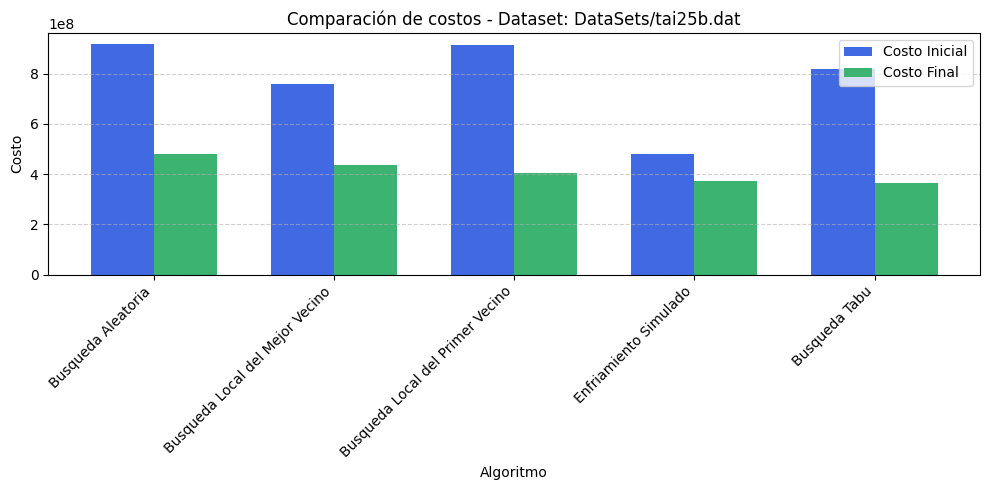

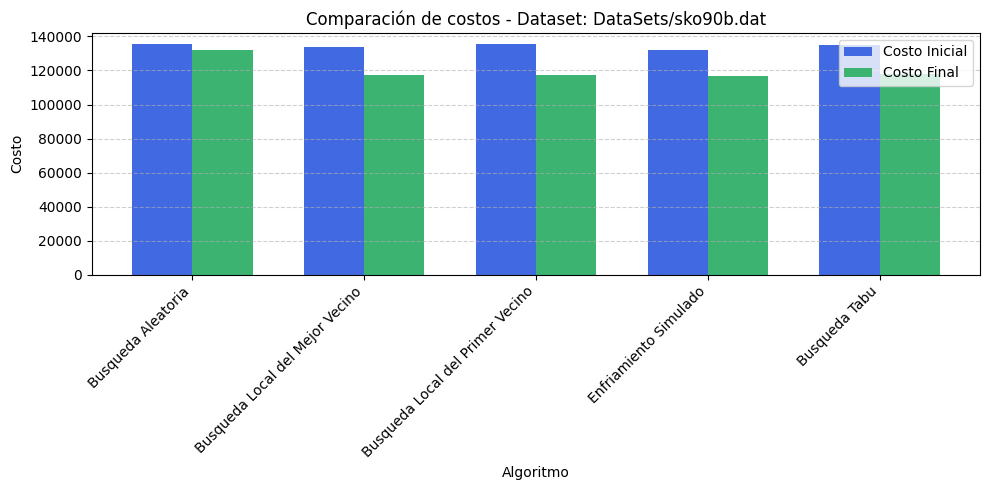

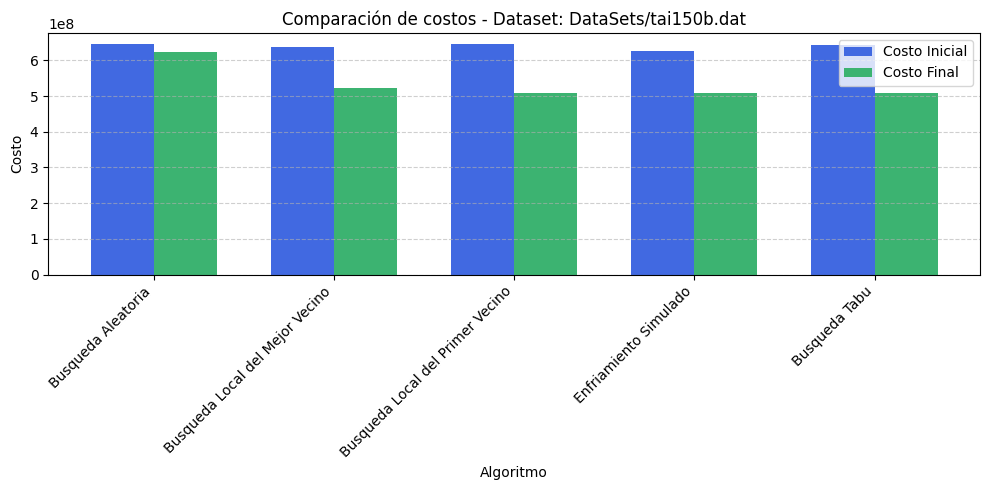

In [79]:
print("\nTablas resumen globales\n")
algoritmos_orden = ["Greedy", "Busqueda Aleatoria", "Busqueda Local del Mejor Vecino", "Busqueda Local del Primer Vecino","Enfriamiento Simulado", "Busqueda Tabu"]  # Ajusta según nombres usados
tabla_resultados_globales(resultados_en_memoria, nombre_algoritmos=algoritmos_orden)
graficar_coste_inicial_final_por_dataset(resultados_en_memoria)
